# Exploring mixture of Gaussians and Annealing

In [3]:
# imports
include("SVGD.jl")

using Plots
using Distributions
using Test
using Statistics
using LinearAlgebra
using JLD
using ForwardDiff
;

### Creating the dataset

In [28]:
# # initial particles

# # heart samples 
# begin
    # x = [range(-2., 2, length=50);]
    # y1 = sqrt.(1 .- (abs.(x) .- 1) .^ 2)
    # y2 = - 3 * sqrt.(1 .- (abs.(x) ./ 2) .^ 0.5)
    # init_particles = hcat(vcat(y1.-1.5, y2.-1.5), vcat(x.+2.5, x.+2.5))
# end

# # cluster samples
# init_particles = (randn(100, 2) ./ 4) .+ [3 2.5]

# # dense samples
init_particles = randn(128, 2) ./ 2 .+ [4 -1]
;

### Mixture of Gaussians
Here we use existing arrays (stored in the statics folder) for Mean, Covariance and mixture priors. Therefore you need to specify the local directory to the GitHub repo `loc_dir`. 

In [18]:
loc_dir = "/Users/saeeds/Dropbox/SVGD/SteinVarGradDescPML"

begin # # Mixture of Gaussians

    # # using the better stored values
    π_array = load(joinpath(loc_dir, "statics/IsolOnes1.jld"), "pis")
    mean_mat = load(joinpath(loc_dir, "statics/IsolOnes1.jld"), "means")
    cov_tensor = load(joinpath(loc_dir, "statics/IsolOnes1.jld"), "covs")

    MixMVN = MixtureModel(MvNormal, [
            (Vector(mean_mat[1, :]), Matrix(cov_tensor[1, :, :])),
            (Vector(mean_mat[2, :]), Matrix(cov_tensor[2, :, :])),
            (Vector(mean_mat[3, :]), Matrix(cov_tensor[3, :, :])),
            (Vector(mean_mat[4, :]), Matrix(cov_tensor[4, :, :])),
            (Vector(mean_mat[5, :]), Matrix(cov_tensor[5, :, :])),
            ], π_array)
end
;

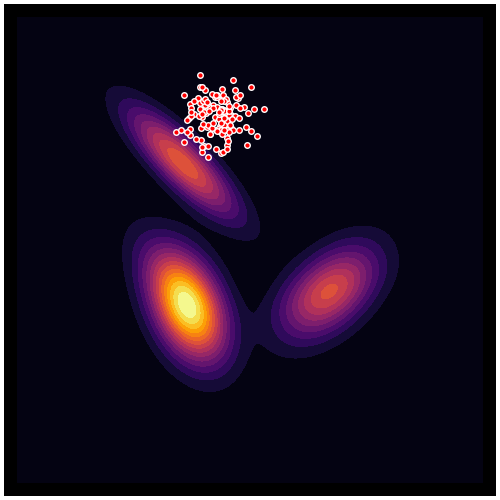

In [29]:
# plotting the PDF and initial particles
# # 2D PDF grid
xx, yy = [-7.:.01:7.;], [-7.:.01:7.;]
mix_grid = pdf_grid(xx, yy, MixMVN)

pyplot(size=(500,500))

contourf(xx, yy, mix_grid,  aspect_ratio = 1, legend=false, border=:none,
    background_color_subplot="black", background_color=:transparent)

scatter!(init_particles[:, 2], init_particles[:, 1], legend=false,
    color="red", aspect_ratio=:equal, axis=nothing)


### Gradient
Since deriving the analytical gradient of log of mixture of multivariate gaussians can be exhausting and prone to mistakes, we use `ForwardDiff` library for numerical but still fast differentiation.

In [30]:
logπ(x) = log(pdf(MixMVN, x))  # although logpdf method exists in Distributions, it was unstable.
dlogπ = x -> ForwardDiff.gradient(logπ, x)  # numeric gradient
num_dlogπ(x) = hcat(dlogπ.(eachrow(x))...)'  # this will help us keep the dimensions correct.
;

### SVGD: Flowing (updating) the particles

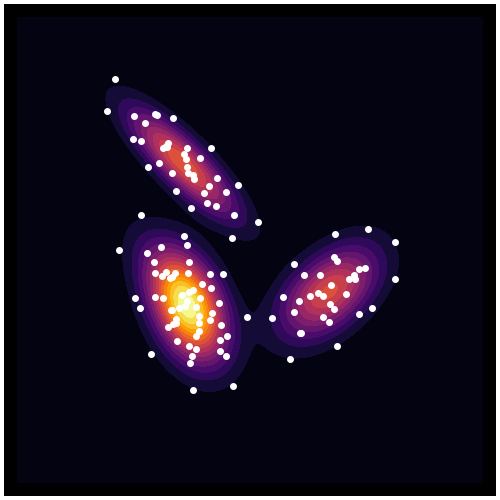

In [31]:
n_ep_ = 24000  # number of epochs
trans_parts = update(init_particles, num_dlogπ, n_epochs=n_ep_)
;

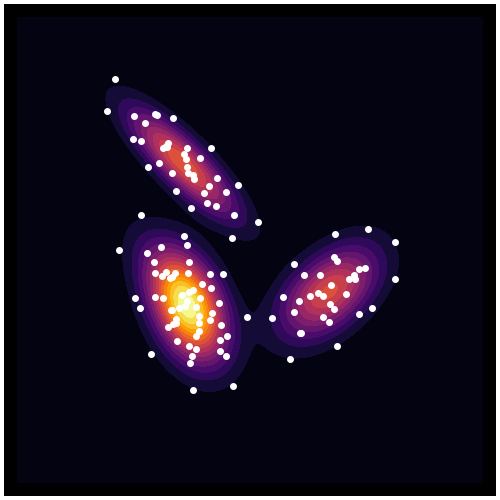

In [32]:
# # plot PDF heatmap and evolved particles
contourf(xx, yy, mix_grid,
    legend=false, border=:none, background_color_subplot="black", background_color=:transparent)

scatter!(trans_parts[:, 2], trans_parts[:, 1], aspect_ratio = 1,
    legend=false, color="white", axis=nothing)
